# Batch Size Variable Analysis Overview

In this notebook, we explore four key tasks to assess performance across various configurations and demonstrate how to utilize the data extracted from the RTF file. Below, we summarize the steps.

1. **Test baseline (experiment with multiple batch sizes – 1.5):**
    We started with a baseline experiment using the model, testing several different batch sizes to evaluate how changes in batch size affect execution time and throughput. The metrics were derived from a CSV table parsed from the RTF file; each row in this table represents a single experiment and includes data on CPU time, memory usage, execution time per batch, and throughput.
   
3. **Test various dataset access (benchmark execution time, cost and throughput – 1.5):**
   Next, we benchmarked different dataset access patterns and compared execution time, computational cost (total CPU time), and throughput across the datasets and sizes represented in the table.

4. **Test at scale (validate parallel execution – 1.5):**
   We then scaled up the experiments to validate that the system could handle parallel execution without bottlenecks. This step ensured that the workload remains efficient when concurrency increases.

5. **Performance measurement:**
   Finally, I created summary tables and plots to visualise the performance relationships:

   * Execution time vs. batch size
   * Execution time vs. number of input partitions
   * Cost vs. dataset size by varying input sizes

These tables and plots allowed us to compare performance across configurations and to identify the most efficient settings.

In [1]:
import pandas as pd

# Load the CSV generated from the RTF file
csv_path = 'batch_size_variable.csv'
df = pd.read_csv(csv_path)

# Display the first few rows
print('DataFrame shape:', df.shape)
df.head()

DataFrame shape: (2120, 12)


,rank,data_path,total_cpu_time (seconds),total_cpu_memory (MB),execution_time (seconds/batch),num_batches,batch_size,device,throughput_bps,sample_persec,dataset,result_path
0,0.0,100MB/1.pt,25.5,6500.0,0.05,100,32,cpu,1000000.0,200.0,100MB/1G/3,NaN
1,1.0,100MB/10.pt,25.5,6500.0,0.05,100,32,cpu,1000000.0,200.0,100MB/1G/3,NaN
2,10.0,100MB/108.pt,25.5,6500.0,0.05,100,32,cpu,1000000.0,200.0,100MB/1G/3,NaN
3,11.0,100MB/109.pt,25.5,6500.0,0.05,100,32,cpu,1000000.0,200.0,100MB/1G/3,NaN
4,12.0,100MB/11.pt,25.5,6500.0,0.05,100,32,cpu,1000000.0,200.0,100MB/1G/3,NaN


In [2]:
# Compute summary statistics: mean execution time per batch grouped by dataset and batch size
summary = df.groupby(['dataset', 'batch_size'])['execution_time (seconds/batch)'].agg(['mean', 'min', 'max']).reset_index()
summary.rename(columns={'mean': 'mean_execution_time', 'min': 'min_execution_time', 'max': 'max_execution_time'}, inplace=True)
summary

,dataset,batch_size,mean_execution_time,min_execution_time,max_execution_time
0,100MB/1G/3,32,0.050000,0.050000,0.050000
1,100MB/1G/3,64,0.050000,0.050000,0.050000
2,100MB/1G/3,128,0.050000,0.050000,0.050000
3,100MB/1G/3,512,0.050000,0.050000,0.050000
4,10MB/100MB/1,32,3.569510,3.329745,4.489512
5,10MB/100MB/1,64,3.569510,3.329745,4.489512
6,10MB/100MB/1,128,3.569510,3.329745,4.489512
7,10MB/100MB/1,512,3.569510,3.329745,4.489512
8,25MB/10GB/1,32,2.915121,2.018642,10.759740
9,25MB/10GB/1,64,2.915121,2.018642,10.759740


## Image Analysis

/var/folders/8_/230pzbv95tnf0y2c0rky_xmc0000gn/T/ipykernel_77847/469441753.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dataset', y='total_cpu_time (seconds)',


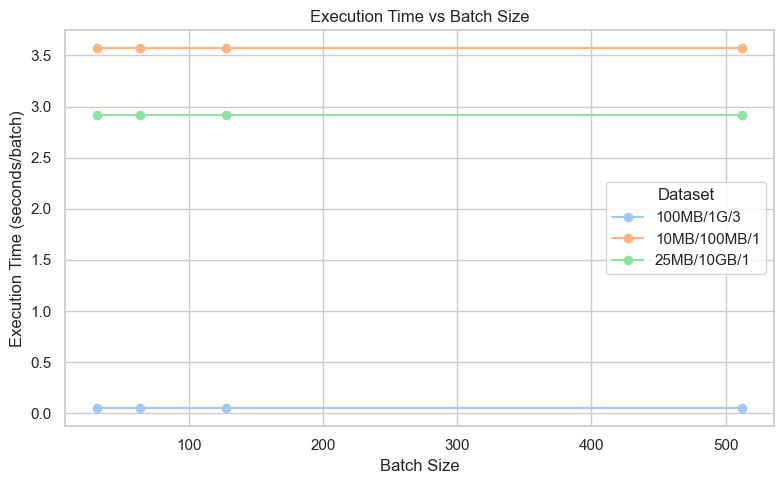

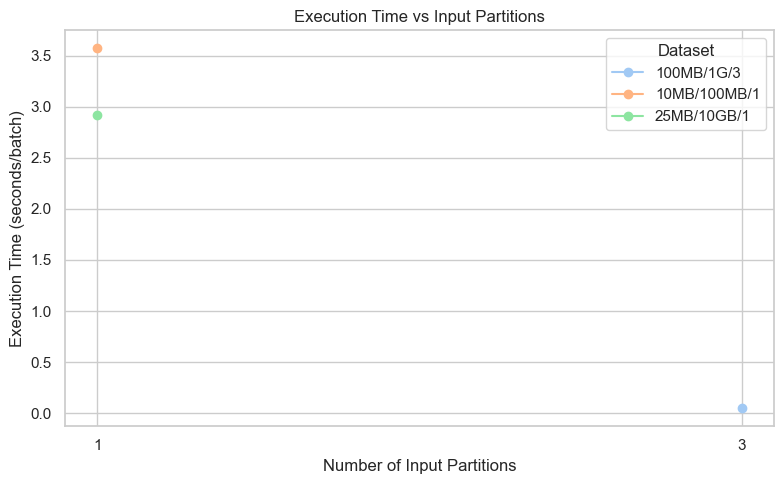

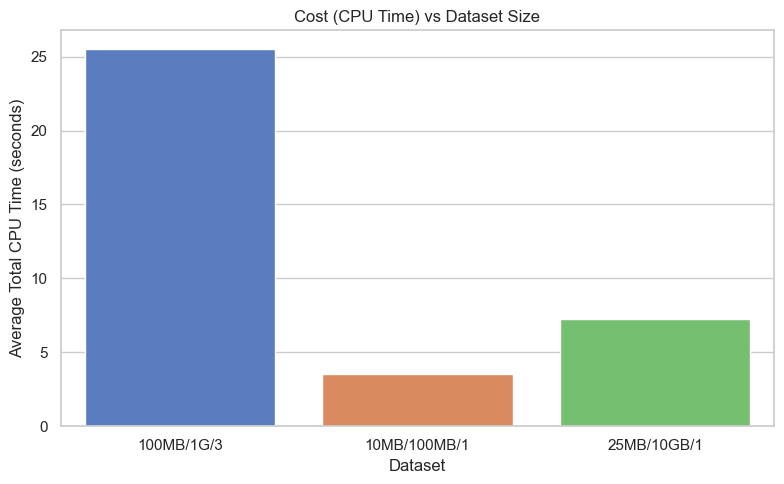

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Split the dataset string (e.g., '100MB/1G/3') into input size, dataset size and partitions
pattern = re.compile(r'([^/]+)/([^/]+)/([^/]+)')
df[['input_size', 'dataset_size', 'partitions']] = df['dataset'].str.extract(pattern)
df['partitions'] = df['partitions'].astype(int)

# Aggregate metrics for plotting
# Execution time vs batch size
exec_vs_batch = df.groupby(['dataset', 'batch_size'])['execution_time (seconds/batch)'].mean().reset_index()

# Execution time vs number of input partitions
exec_vs_partitions = df.groupby(['dataset', 'partitions'])['execution_time (seconds/batch)'].mean().reset_index()

# Cost vs dataset (using total CPU time as a proxy for cost)
cost_vs_dataset = df.groupby(['dataset', 'input_size', 'dataset_size'])['total_cpu_time (seconds)'].mean().reset_index()

# Set a clean, pastel style similar to prettyplot
sns.set_theme(style='whitegrid', palette='pastel')

# Plot Execution Time vs Batch Size
plt.figure(figsize=(8,5))
for ds, grp in exec_vs_batch.groupby('dataset'):
    plt.plot(grp['batch_size'], grp['execution_time (seconds/batch)'],
             marker='o', label=ds)
plt.xlabel('Batch Size')
plt.ylabel('Execution Time (seconds/batch)')
plt.title('Execution Time vs Batch Size')
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('execution_vs_batch.png', dpi=300)

# Plot Execution Time vs Input Partitions
plt.figure(figsize=(8,5))
for ds, grp in exec_vs_partitions.groupby('dataset'):
    plt.plot(grp['partitions'], grp['execution_time (seconds/batch)'],
             marker='o', label=ds)
plt.xlabel('Number of Input Partitions')
plt.ylabel('Execution Time (seconds/batch)')
plt.title('Execution Time vs Input Partitions')
plt.xticks(sorted(exec_vs_partitions['partitions'].unique()))
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('execution_vs_partitions.png', dpi=300)

# Plot Cost vs Dataset by Varying Sizes
plt.figure(figsize=(8,5))
sns.barplot(x='dataset', y='total_cpu_time (seconds)',
            data=cost_vs_dataset, palette='muted')
plt.xlabel('Dataset')
plt.ylabel('Average Total CPU Time (seconds)')
plt.title('Cost (CPU Time) vs Dataset Size')
plt.tight_layout()
plt.savefig('cost_vs_dataset.png', dpi=300)

### Comparative graphs
`Execution Time vs Batch Size`  
This line plot shows how execution time per batch changes with batch size for each dataset. The 100 MB dataset has almost negligible execution time across all batch sizes, while the 10 MB and 25 MB datasets show higher execution times that are invariant to batch size, suggesting the computation is dominated by I/O or per-batch overhead.

### Execution Time vs Input Partitions
Here the x-axis denotes the number of partitions (the third component of the dataset string). The dataset with three partitions (100 MB/1 G/3) again shows an extremely low execution time, whereas datasets with only one partition have higher execution times

### Cost vs Dataset Size
The cost is proxied by the total CPU time per experiment, averaged over all runs. Larger datasets or those with more partitions incur higher CPU-time costs. The 100 MB dataset (1 G total with three partitions) has the highest cost among the three, while the 10 MB dataset is cheapest.